# Assignment 3

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).
---

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set_style(style="darkgrid")  # default style
from sklearn.model_selection import train_test_split
import tensorflow as tf
from matplotlib import pyplot as plt

2024-06-01 16:24:03.433118: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


This lab continues our study of linear regression. You'll train your first models with Tensorflow, using a real dataset to predict car prices from their features. Note that Tensorflow is a rapidly changing library. This means you'll often see warnings about deprecations. You can ignore the warnings in our labs.

---
### Step 1: Data ingestion

You'll use the [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile)  from 1985 Ward's Automotive Yearbook that is part of the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets).

In [2]:
# Provide the names for the feature columns since the CSV file with the data 
# does not have a header row.
cols = ['symboling', 'losses', 'make', 'fuel-type', 'aspiration', 'num-doors',
        'body-style', 'drive-wheels', 'engine-location', 'wheel-base',
        'length', 'width', 'height', 'weight', 'engine-type', 'num-cylinders',
        'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-ratio',
        'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

# Load the data from a CSV file into a pandas dataframe. Remember that each row
# is an example and each column in a feature.
car_data_init = pd.read_csv(
    'https://storage.googleapis.com/ml_universities/cars_dataset/cars_data.csv',
    sep=',', names=cols, header=None, encoding='latin-1')

# Display top five rows
print('Shape of data:', car_data_init.shape)
car_data_init.head()

Shape of data: (205, 26)


,symboling,losses,make,fuel-type,aspiration,num-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


---
### Step 2: Data preprocessing

This step is essential for preparing the data in a format that is suitable for ML algorithms. It helps ensure data quality and improvements in model performance.

### <span style="color:chocolate">Exercise 1:</span> Column selection (5 points)

To keep things simple, you will:

1. Retain only the following columns: ['horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']. Name the new dataframe *car_data*.
2. Display the data type of each column;
3. Convert the data type of each columns to numeric. Coerce missing values to NaN. Hint: use <span style="color:chocolate">pd.to_numeric()</span> method;
4. Display the data type of each column after the transformation performed at point 3.

In [3]:
# 1
car_data = car_data_init[['horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']]

In [4]:
# 2
def show_column_dtypes(df: pd.DataFrame):
    """ Prints the data type for each column in a dataframe.

    Args:
        df (pd.DataFrame)
    """
    for col in df.columns:
        print(f"{col}: {df[col].dtype}")

show_column_dtypes(car_data)

horsepower: object
peak-rpm: object
city-mpg: int64
highway-mpg: int64
price: object


In [5]:
# 3
car_data = car_data.apply(pd.to_numeric, errors='coerce')

In [6]:
# 4
show_column_dtypes(car_data)

horsepower: float64
peak-rpm: float64
city-mpg: int64
highway-mpg: int64
price: float64


### <span style="color:chocolate">Exercise 2:</span> Example (row) selection (5 points)

To keep things simple again, you will:

1. Print the shape of the car_data;

2. Remove examples (rows) that have missing value(s). Note that in doing so, you will overwrite the car_data dataset. You should end up with 199 examples after this cleaning.

3. Print the shape of the car_data again.

It's important to acknowledge that there are multiple approaches to handling missing features, and simply discarding examples with any missing feature, though straightforward, may not be the most optimal solution. However, for the sake of simplicity, you will implement this strategy in this assignment.

In [7]:
# 1
print(car_data.shape)

(205, 5)


In [8]:
# 2
car_data.dropna(how='any', inplace=True)

In [9]:
# 3
print(car_data.shape)

(199, 5)


### <span style="color:chocolate">Exercise 3:</span> Data shuffling (10 points)

Since you'll be using Batch Gradient Descent (BGD) for training, it is important that **each batch is a random sample of the data** so that the gradient computed is representative. Note that the original data (above) appears sorted by *make* in alphabetic order.

Using NumPy and Pandas methods:

1. Create a list of indices corresponding to the rows in the car_data dataset. Call this list *indices*. Print this list;

2. Shuffle *indices* using the <span style="color:chocolate">np.random.permutation()</span> method. Call the resulting array *shuffled_indices*. Print this array;
    
3. Use the method <span style="color:chocolate">dataframe.reindex()</span> to change the ordering of the car_data dataset based on the order in the *shuffled_indices* array. Note that in doing so, you will overwrite the original dataset. Print the top 5 rows.

In [10]:
np.random.seed(0)
# YOUR CODE HERE

# 1
indices = car_data.index
print(indices)

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,  10,
       ...
       195, 196, 197, 198, 199, 200, 201, 202, 203, 204],
      dtype='int64', length=199)


In [11]:
# 2
shuffled_indices = np.random.permutation(indices)
print(shuffled_indices)

[ 19 175 109  95 182 189   5 145  13 166  64 127 170 151  83   7  34 135
  38  77 165 150  48 164  63 125 184 190 100  47  17  58  86 113  23 194
 141   4 143 199 159  69  27 137 152  66   8  78 101 172  74 202  89  99
 155  25  31 116  41  59 136 188 186  20 158 142  57 168  54 115 144  92
  93 126 149 187 111  15  28 104 121  49 200 110  65   2  62 179 132  46
  11 192  76 197 183 173 128  96 114 163 196  53   0  97 112  98  67 147
  42  72  52  51  88  14 156  24 191 140  21  16  81 107  55 103  79   3
 119 169 203   6  71  87 124 160 176 161  94 177  12 122 105  36  60  68
   1 123 167  43 108 138 204  18  39 139  56 162 134  35  29 117 157  32
 185 133 181  33 148 174 153  30 102  85  82 118 154 201  75  80  26 171
  84 193 180 195  40  61 146  91  73  90  37  22  10 106  70 198 120  50
 178]


In [12]:
# 3
car_data = car_data.reindex(labels=shuffled_indices, axis='index')
car_data.head(5)

,horsepower,peak-rpm,city-mpg,highway-mpg,price
19,70.0,5400.0,38,43,6295.0
175,92.0,4200.0,27,32,9988.0
109,97.0,5000.0,19,24,12440.0
95,69.0,5200.0,31,37,7799.0
182,52.0,4800.0,37,46,7775.0


### <span style="color:chocolate">Exercise 4:</span> Define outcome and features (5 points)

Create two dataframes as follows:

1. The first dataframe contains our outcome of interest: ['price']. Note, this is what we are aiming to predict. Name this dataframe Y. Print shape of Y.
2. The second dataframe contains our features of interest: ['horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg']. Name this dataframe X. Print shape of X.


In [13]:
# YOUR CODE HERE

# 1
Y = car_data['price']
Y.shape

(199,)

In [14]:
# 2
X = car_data[['horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg']]
X.shape

(199, 4)

### <span style="color:chocolate">Exercise 5:</span> Data splits (10 points)

Using the <span style="color:chocolate">train_test_split()</span> method available in scikit-learn:
1. Partition the (X, Y) data into training, validation, and test sets using a splitting rule of [60%, 20%, 20%], with a random state set to 1234. Name the resulting dataframes as follows: X_train, X_val, X_test, Y_train, Y_val, Y_test. Hint: To create these three partitions you will utilize the train_test_split() method twice. You should obtain [119, 40, 40] examples for training, validation, and test, respectively.
2. Print the shape of each dataframe.

Note: The validation set is crucial for evaluating different hyperparameter configurations and selecting those that yield optimal model performance. This approach avoids utilizing the test dataset during model training, as it is assumed to be "unknown" at that stage.

In [15]:
# YOUR CODE HERE

# 1
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.4)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=.5)

In [16]:
# 2
for df in (X_train, X_val, X_test, Y_train, Y_val, Y_test):
    print(f"{df.shape}")

(119, 4)
(40, 4)
(40, 4)
(119,)
(40,)
(40,)


### <span style="color:chocolate">Exercise 6:</span> Data standardization (10 points)

With this concept in mind, complete the following tasks:

1. Output the quantile values (0.25, 0.5, 0.75, 0.95) for all features in the X_train dataset. Are these values uniformly scaled across features?

2. Standardize all features in X_train, X_val, and X_test. Label the resulting dataframes as X_train_std, X_val_std, and X_test_std, respectively. Hint: standardize the validation and test data using the mean and standard deviation computed from the training data. Why?

3. Similar to point 2. but now standardize the outcome variable. Label the resulting dataframes as Y_train_std, Y_val_std, and Y_test_std.

In [17]:
# YOUR CODE HERE
# 1
X_train.quantile([0.25, 0.5, 0.75, 0.95])
# MY ANSWER: These quantiles are not uniformly scaled across features

,horsepower,peak-rpm,city-mpg,highway-mpg
0.25,70.0,4800.0,19.0,25.0
0.50,95.0,5200.0,25.0,30.0
0.75,120.5,5500.0,31.0,37.0
0.95,176.6,6000.0,37.1,42.1


In [18]:
# 2
def standardize_data(data, based_on):
    """
    Standardizes the given data based on the mean and std of another dataset.

    Args:
        data (pd.DataFrame or pd.Series): The data to be standardized.
        based_on (pd.DataFrame or pd.Series): The reference data from which to derive the mean and std.

    Returns:
        pd.DataFrame or pd.Series: A standardized DataFrame or Series.
    """
    
    # get the mean and std that we want to use (expect this to be the "training" splits)
    means = based_on.mean()
    stds = based_on.std()

    if isinstance(data, pd.Series):
        # Standardize the data
        data_standardized = (data - means) / stds

    elif isinstance(data, pd.DataFrame):
        # Ensure that we are using the correct mean and std for each column
        data_standardized = data.copy()
        for column in data.columns:
            data_standardized[column] = (data[column] - means[column]) / stds[column]

    return data_standardized


X_train_std = standardize_data(X_train, based_on=X_train)
X_val_std = standardize_data(X_val, based_on=X_train)
X_test_std = standardize_data(X_test, based_on=X_train)

In [19]:
# 3
Y_train_std = standardize_data(data=Y_train, based_on=Y_train)
Y_val_std = standardize_data(data=Y_val, based_on=Y_train)
Y_test_std = standardize_data(data=Y_test, based_on=Y_train)

---
### Step 3: Exploratory data analysis (EDA)

EDA plays a very important role in ML. The goal here is to develop a good understanding of our dataset, identify any data quality issues, understand patterns and relationships, which in turn, aids in subsequent modeling and interpretations.

### <span style="color:chocolate">Exercise 7:</span> Scatterplot matrix (10 points)

In this exercise you will use some simple yet useful techniques to visualize the distribution of the data. 

Let's start with:

1. A scatterplot matrix to visualize the pair-wise correlations between different features and outcome in the (X_train_std, Y_train_std) data. You will use the <span style="color:chocolate">sns.pairplot()</span> method from the seaborn library imported at the top of the notebook;
2. Is any of the variables in the data normally distributed? Is it necessary for the explanatory or target variable to be normally distributed in order to train a ML model?

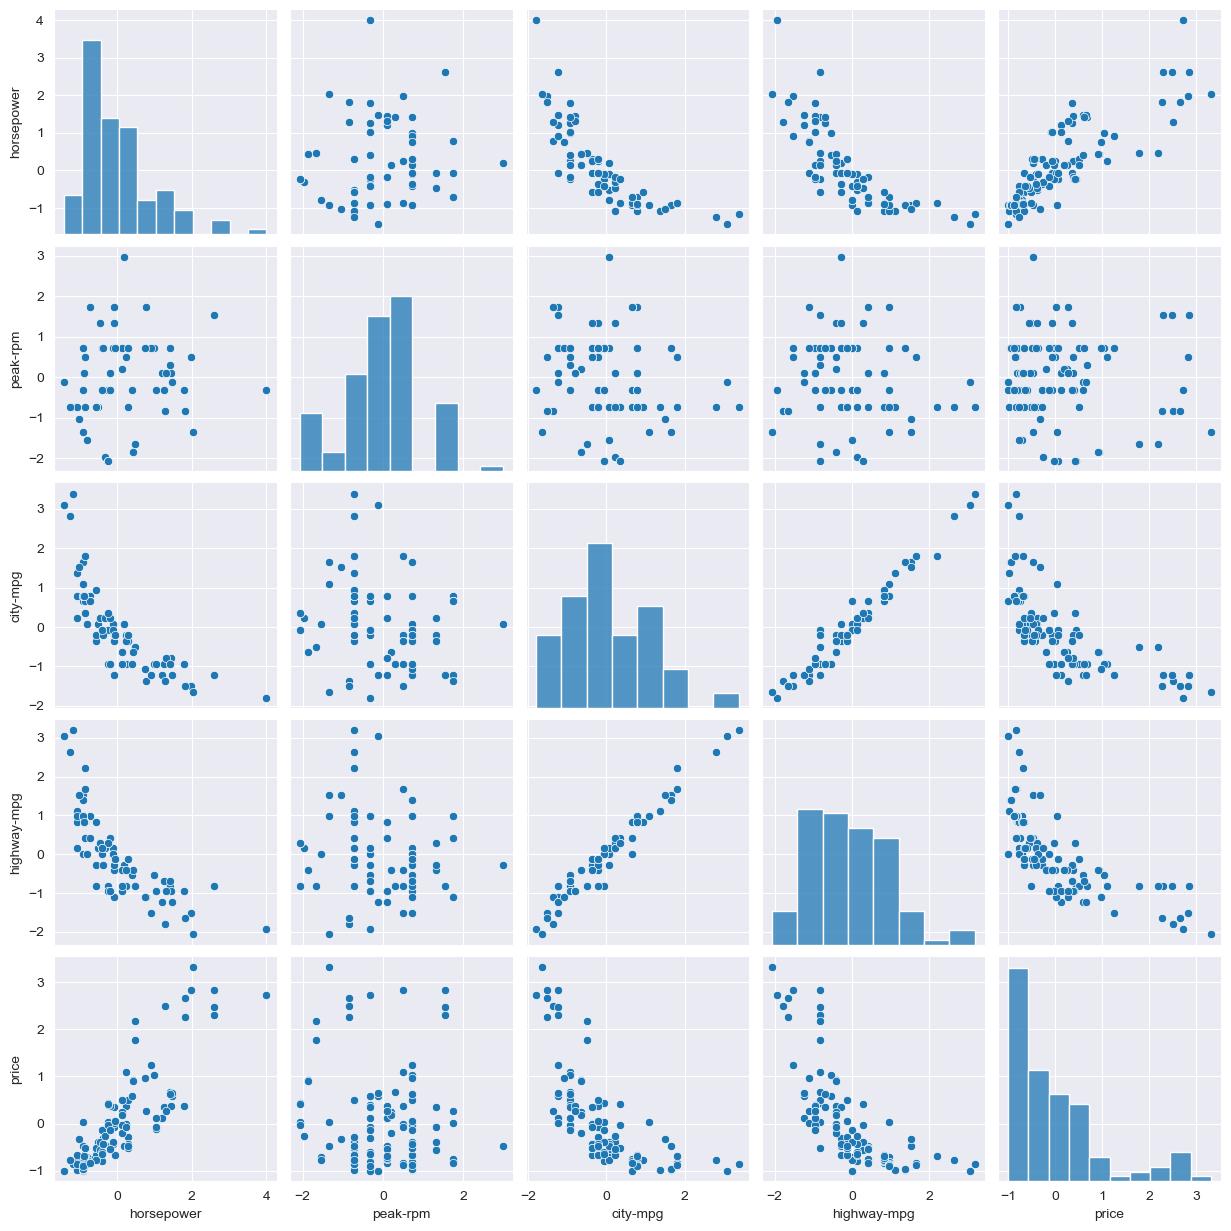

In [20]:
# YOUR CODE HERE
# 1
# Combine the data frames first
combined_train_std = pd.concat([X_train_std, Y_train_std], axis=1)

# plot the 
sns.pairplot(combined_train_std)
plt.show()

In [21]:
# 2
# peak_rpm and city-mpg both appear to be relatively normally distributed in the standardized datasets. 
# It is not strictly required for any common ML models to have normally distributed explanatory or target variables. 
# come ML models are sensitive to the scale of the variables, so normalization can help the model train more quickly.

### <span style="color:chocolate">Exercise 8:</span> Correlation matrix (10 points)

In this exercise you will:

1. Plot a correlation matrix in the form of a heatmap to visualize the linear relationships between different features and outcome in the (X_train_std, Y_train) data. Hint: this example here is very useful: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
    
2. Answer the following questions: 
 - Which two features are likely to be most redundant?
 - Which feature is likely to be least useful for predicting price?

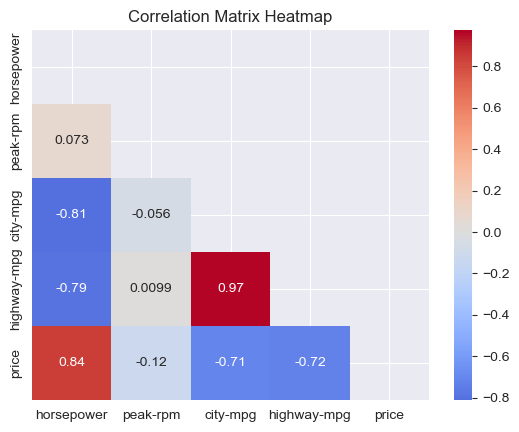

In [22]:
# YOUR CODE HERE
# 1

# Compute the correlation matrix
corr_matrix = combined_train_std.corr()

# Generate a mask to block the upper triangle for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, center=0, cmap='coolwarm', annot=True)

plt.title('Correlation Matrix Heatmap')
plt.show()

In [23]:
# 2
# Which two features are likely to be most redundant?
#   -> city mpg and highway are most likely to be redundant because they have an almost perfect correlation of 0.97
# Which feature is likely to be least useful for predicting price?
#   -> preak rpm will be least useful because it has a very low correlation with price (0.12) compared to the other features (0.84, -0.71, -0.72)

---
### Step 4: Modeling

### <span style="color:chocolate">Exercise 9:</span> Baseline model (5 points)

Let's start by evaluating a baseline model. Precisely, you'll use the average price of cars in the training set as our baseline model -- that is, the baseline always predicts the average price regardless of the input.

1. Implement this baseline using the Y_train_std data and print the average price. Note: You can revert the price variable to the original scale for interpretation purposes.

In [24]:
# YOUR CODE HERE

# The baseline model always returns the mean of y_train_std (which is 0 by definiton)
baseline_prediciton_std = Y_train_std.mean()
baseline_prediciton_reverted = (baseline_prediciton_std * Y_train.std()) + Y_train.mean()

print(f"Average price (standardized) = {baseline_prediciton_std}")
print(f"Average price (reverted) = {baseline_prediciton_reverted}")

Average price (standardized) = -3.749335109422141e-17
Average price (reverted) = 13484.042016806723


### <span style="color:chocolate">Exercise 10:</span> Improvement over Baseline with TensorFlow (10 points)

Let's train a linear regression model much like we did in the previous assignment, but this time using TensorFlow. 

1. Fill in the <span style="color:green">NotImplemented</span> parts of the build_model() function below by following the instructions provided as comments. Hint: refer to Demo 3 in [bCourses/Modules/Live Session Demos](https://bcourses.berkeley.edu/courses/1534588/files/88733489?module_item_id=17073646) for an example.
2. Build and compile a model using the build_model() function and the (X_train_std, Y_train_std) data. Set learning_rate = 0.0001. Call the resulting object *model_tf*.
3. Train *model_tf* using the (X_train_std, Y_train_std) data. Set num_epochs = 5. Pass the (X_val_std, Y_val_std) data for validation. Hint: see the documentation behind the [tf.keras.Model.fit()](https://bcourses.berkeley.edu/courses/1534588/files/88733489?module_item_id=17073646) method.
3. Generate a plot with the loss values on the y-axis and the epoch number on the x-axis for visualization. Make sure to include axes name and title. Hint: check what the [tf.keras.Model.fit()](https://bcourses.berkeley.edu/courses/1534588/files/88733489?module_item_id=17073646) method returns.

More notes on point 1: the idea is to build a *computational graph* for linear regression, and then send data through it. There are many ways to build graphs, but [TenforFlow Keras API](https://www.tensorflow.org/api_docs/python/tf/keras) is recommended. 

In [25]:
def build_model(num_features, learning_rate, optimizer = None, loss='mse'):
  """Build a TF linear regression model using Keras.

  Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  # This is not strictly necessary, but each time you build a model, TF adds
  # new nodes (rather than overwriting), so the colab session can end up
  # storing lots of copies of the graph when you only care about the most
  # recent. Also, as there is some randomness built into training with SGD,
  # setting a random seed ensures that results are the same on each identical
  # training run.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Build a model using keras.Sequential. While this is intended for neural
  # networks (which may have multiple layers), we want just a single layer for
  # linear regression.
  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(num_features,)),  # specify input shape here
    tf.keras.layers.Dense(
        units=1,                    # output dim
        use_bias=True,              # use a bias (intercept) param
        kernel_initializer = tf.ones_initializer,  # initialize params to 1
        bias_initializer = tf.ones_initializer,    # initialize bias to 1
      )
    ])

  # We need to choose an optimizer. We'll use GD, which is actually mini-batch GD
  if optimizer == None:
    optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate)

  # Finally, compile the model. This finalizes the graph for training.
  # We specify the loss and the optimizer above
  model.compile(optimizer = optimizer, loss=loss)
    
  return model

In [26]:
tf.random.set_seed(0)

# YOUR CODE HERE
# 2. Build and compile model
num_features = X_train_std.shape[1]
model_tf = build_model(num_features, learning_rate=.0001)

# 3. Fit the model
model_tf_history = model_tf.fit(x = X_train_std, 
                                    y = Y_train_std, 
                                    epochs = 5, 
                                    validation_data = (X_val_std, Y_val_std))

Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 6.0592 - val_loss: 3.8640
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.0420 - val_loss: 3.8527
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.0249 - val_loss: 3.8414
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.0078 - val_loss: 3.8302
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.9907 - val_loss: 3.8190


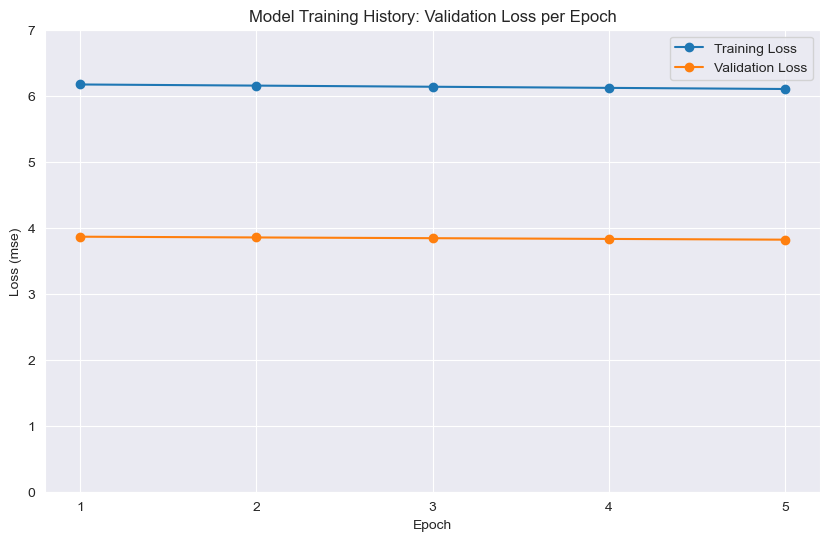

In [27]:
# 4. Generate a plot of loss values across the epochs

def plot_training_history(model_history):
    """generates a plot to visualize loss (mse) at each epoch when the model was trained. 

    Args:
        model: a tf.keras.model object that has been pretrained and has a model.history attribute
    """

    history = model_history.history
    og_epochs = range(1, len(history['loss']) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(og_epochs, history['loss'], label = 'Training Loss', marker = 'o')
    plt.plot(og_epochs, history['val_loss'], label = 'Validation Loss', marker = 'o')

    plt.xlabel('Epoch')
    plt.xticks(og_epochs)
    plt.ylabel('Loss (mse)')
    plt.ylim(bottom=0, top=7)

    plt.title('Model Training History: Validation Loss per Epoch')
    plt.legend()
    plt.show()

    # print out the history values too
    history

plot_training_history(model_tf_history)

---
### Step 5: Hyperparameter tuning

Hyperparameter tuning is a crucial step in optimizing ML models. It involves systematically adjusting hyperparameters such as `learning rate`, `number of epochs`, and `optimizer` to find the model configuration that leads to the best generalization performance.

This tuning process is typically conducted by monitoring the model's performance on the validation vs. training set. It's important to note that using the test set for hyperparameter tuning can compromise the integrity of the evaluation process by violating the assumption of "blindness" of the test data.

### <span style="color:chocolate">Exercise 11:</span> Hyperparameter tuning (10 points)

1. Fine-tune the hyperparameters of *model_tf* to determine the setup that yields the most optimal generalization performance. Feel free to explore various values for the hyperparameters. Hint: ask your instructors and TAs for help if in doubt.

After identifying your preferred model configuration, print the following information:

2. The learned parameters of the model (this should include the bias term). Hint: use  <span style="color:chocolate">model_tf.layers[0].get_weights()</span>.
3. The loss at the final epoch on both the training and validation datasets;
4. The percentage difference between the losses observed on the training and validation datasets.


Please note that we will consider 'optimal model configuration' any last-epoch loss that is below 0.35.

In [28]:
tf.random.set_seed(0)

# 1
# YOUR CODE HERE
def test_learning_rates(learning_rates: list):
    """
    Tests multiple learning rates to determine the best one based on validation loss.

    Args:
    learning_rates (list of floats): A list of learning rates to be tested.

    Returns:
    tuple: A tuple containing:
        - best_model : A dictionary with the best learning rate found.
        - best_params (dict): A dictionary with the best learning rate found and the associated validation loss.
    """

    best_params = {}
    num_features = X_train_std.shape[1]

    for i, lr in enumerate(learning_rates):
        print(f"\nlearning rate = {lr}")

        model = build_model(num_features, lr)

        model_fit_history = model.fit(x = X_train_std, 
                              y = Y_train_std, 
                              epochs = 5, 
                              validation_data = (X_val_std, Y_val_std),
                              verbose = 0)
        
        # print the final validation data loss value in model training history
        this_val_loss = model_fit_history.history['val_loss'][-1]
        print(f" val_loss = {round(this_val_loss, 6)}")

        if i == 0:
            # on first pass, need to initialize a loss value
            best_model = model
            best_params['learning_rate'] = lr
            best_params['best_val_loss'] = this_val_loss
        elif this_val_loss < best_params['best_val_loss']:
            best_model = model
            best_params['learning_rate'] = lr
            best_params['best_val_loss'] = this_val_loss

    print("- "*40)
    print(f"{best_params = }")
    return best_params


# search a list of learning rates to find the one that gives the best validation loss
params = test_learning_rates([0.00001, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4])

# recreate the model with the best learning rate value
model_tf = build_model(num_features, params['learning_rate'])
model_fit_history = model_tf.fit(X_train_std, Y_train_std, epochs = 5, validation_data = (X_val_std, Y_val_std))


learning rate = 1e-05
 val_loss = 3.869666

learning rate = 0.0001
 val_loss = 3.819041

learning rate = 0.001
 val_loss = 3.356526

learning rate = 0.01
 val_loss = 1.233044

learning rate = 0.1
 val_loss = 0.345144

learning rate = 0.2
 val_loss = 0.328028

learning rate = 0.3
 val_loss = 0.341628

learning rate = 0.4
 val_loss = 0.845427
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
best_params = {'learning_rate': 0.2, 'best_val_loss': 0.3280281126499176}
Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.2843 - val_loss: 0.4312
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4035 - val_loss: 0.3720
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3396 - val_loss: 0.3463
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3203 - val_loss: 0.3340
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3135 - val_loss: 0.3280


NOTE: To get the validation loss below 0.35, all we need to do is change the learning_rate to 0.1 or 0.2. We do not need add epochs or change the optimizer being used, although those would probably improve the model performance as well.

In [29]:
# 2. The learned parameters of the model 
model_tf.layers[0].get_weights()

[array([[ 0.77685237],
        [-0.20171875],
        [ 0.1122911 ],
        [-0.08313856]], dtype=float32),
 array([0.02509132], dtype=float32)]

In [30]:
# 3. The loss at the final epoch on both the training and validation datasets;
final_train_loss = model_fit_history.history['loss'][-1]
final_val_loss = model_fit_history.history['val_loss'][-1]

print("final training loss: ", final_train_loss)
print("final validation loss: ", final_val_loss)

final training loss:  0.30027803778648376
final validation loss:  0.3280281126499176


In [31]:
# 4. The percentage difference between the losses observed on the training and validation datasets.
percentage_difference = ((final_train_loss - final_val_loss) / final_train_loss) * 100

print(f"The percentage difference between the training and validation losses is {percentage_difference:.3f}%")

The percentage difference between the training and validation losses is -9.241%


---
### Step 6: Evaluation and Generalization


Now that you've determined the optimal set of hyperparameters, it's time to evaluate your optimized model on the test data to gauge its performance in real-world scenarios, commonly known as inference.

### <span style="color:chocolate">Exercise 12:</span> Computing MSE (10 points)

1. Calculate MSE on both (X_train_std, Y_train_std) and (X_test_std, Y_test_std) datasets. Hint: You can utilize the <span style="color:chocolate">model.evaluate()</span> method provided by tf.keras.

In [32]:
# YOUR CODE HERE
model_tf.evaluate(X_train_std, Y_train_std, verbose=0, return_dict=True)

{'loss': 0.2623060643672943}

In [33]:
model_tf.evaluate(X_test_std, Y_test_std, verbose=0, return_dict=True)

{'loss': 0.34332162141799927}

2. Does the model demonstrate strong generalization capabilities? Provide an explanation based on your observations.

`ANSWER`: the model does generalize well. the mse on teh test dataset is 0.25, which is not as good as the mse on the train dataset (as we would expect) but it is still within the 0.35 threshold for an 'optimal model configuration' that we defined above in exercise 11

3. Generate a plot to visualize the accuracy of the predictions. Plot the actual (observed) Y_test values on the x-axis and the predicted Y_test values on the y-axis. Additionally, include a 45-degree line in the plot for reference. Ensure that the plot contains appropriate axis labels and a title. Provide commentary on the model's fit based on this visualization. Hint: You can utilize the <span style="color:chocolate">model.predict()</span> method available in tf.keras. 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


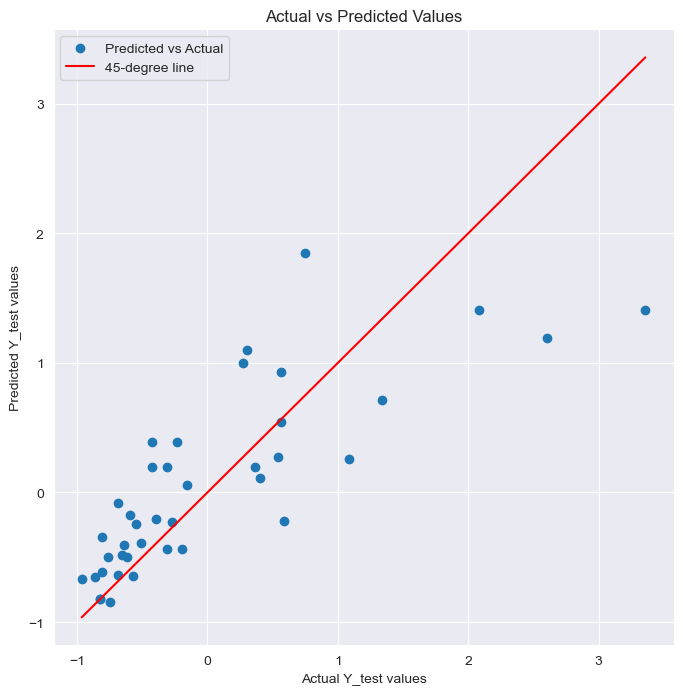

In [34]:
# YOUR CODE HERE
def plot_predictions(model):

    plt.figure(figsize=(8, 8))

    # Make predictions from X_test
    Y_pred_std = model.predict(X_test_std)
    plt.scatter(Y_test_std, Y_pred_std, label='Predicted vs Actual')

    # create and plot a red 45 degree line
    x = np.linspace(start = min(Y_test_std), 
                    stop = max(Y_test_std))
    y = x
    plt.plot(x, y, color='red', label='45-degree line')

    # Add labels and title
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Actual Y_test values')
    plt.ylabel('Predicted Y_test values')
    plt.legend()
    # plt.grid(True)

    # Show the plot
    plt.show()

plot_predictions(model_tf)

`answer:` the model predictions seems to match the actual Y_test values fairly well. There is a slight tendency for the model to overestimate the Y values, since we see more of the blue dots above the red line than we see below it. 

----
### <span style="color:chocolate">Bonus question</span> (20 points)

In Exercise 12, you reported an aggregated MSE. Let's revisit the exercise by:

1. Conducting a subgroup model evaluation. More precisely, compute the test data MSE based on various car subgroups such as make, engine size, fuel type, etc.

2. Answering the question: is the model "fair" to your chosen car subgroups in our data?

In [35]:
# YOUR CODE HERE